In [5]:
import geopandas as gpd

shp = "/home/onyxia/work/data/projet_eval/PI_strates_pyrenees_32630.shp"
gdf = gpd.read_file(shp)

print("Colonnes :", gdf.columns.tolist())
print(gdf.head())

for col in gdf.columns:
    try:
        print(col, ":", gdf[col].unique()[:10])
    except:
        pass


Colonnes : ['id', 'strate', 'comment', 'geometry']
   id  strate              comment  \
0   1       3          lande basse   
1   2       3          lande basse   
2   3       3          lande basse   
3   4       3  lande basse + blocs   
4   5       3  lande basse + blocs   

                                            geometry  
0  POLYGON ((686851.853 4758529.727, 686852.251 4...  
1  POLYGON ((686804.228 4758526.185, 686806.22 47...  
2  POLYGON ((686820.534 4758490.129, 686821.53 47...  
3  POLYGON ((686829.616 4758475.777, 686830.015 4...  
4  POLYGON ((686801.094 4758794.649, 686802.091 4...  
id : [ 1  2  3  4  5  6  7  8  9 10]
strate : [3 2 4 1]
comment : ['lande basse' 'lande basse + blocs' 'lande basse ouverte'
 'lande basse ombragée' 'lande basse éparse sur éboulis' None
 'lande basse + drailles' 'résineux éparses' 'lande ouverte + draille']
geometry : <GeometryArray>
[<POLYGON ((686851.853 4758529.727, 686852.251 4758529.756, 686852.266 475852...>,
 <POLYGON ((686804.22

In [6]:
import os

results_dir = "/home/onyxia/work/results"
fig_dir = os.path.join(results_dir, "figure")

os.makedirs(results_dir, exist_ok=True)
os.makedirs(fig_dir, exist_ok=True)


In [8]:
import geopandas as gpd

shp_path = "/home/onyxia/work/data/projet_eval/PI_strates_pyrenees_32630.shp"
gdf = gpd.read_file(shp_path)

gdf.head()


,id,strate,comment,geometry
0,1,3,lande basse,"POLYGON ((686851.853 4758529.727, 686852.251 4..."
1,2,3,lande basse,"POLYGON ((686804.228 4758526.185, 686806.22 47..."
2,3,3,lande basse,"POLYGON ((686820.534 4758490.129, 686821.53 47..."
3,4,3,lande basse + blocs,"POLYGON ((686829.616 4758475.777, 686830.015 4..."
4,5,3,lande basse + blocs,"POLYGON ((686801.094 4758794.649, 686802.091 4..."


In [9]:
def count_polygons_by_class(gdf, col="strate"):
    return gdf[col].value_counts().sort_index()


In [10]:
poly_counts = count_polygons_by_class(gdf, "strate")
poly_counts


strate
1    28
2    69
3    78
4    31
Name: count, dtype: int64

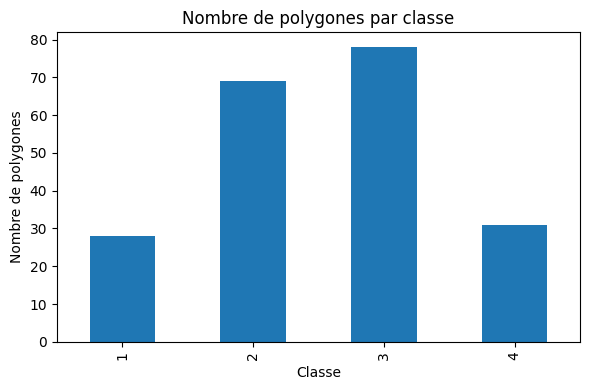

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,4))
poly_counts.plot(kind="bar", ax=ax)
ax.set_title("Nombre de polygones par classe")
ax.set_xlabel("Classe")
ax.set_ylabel("Nombre de polygones")
fig.tight_layout()

fig.savefig("/home/onyxia/work/results/figure/diag_baton_nb_poly_by_class.png")
plt.show()


In [12]:
from osgeo import gdal, ogr
import numpy as np

def rasterize_strata_gdal(shp_path, ref_raster_path, out_raster_path, attr="strate"):
    """
    Rasterise un shapefile de strates en utilisant GDAL uniquement.
    """
    # Ouvrir raster de référence
    ref = gdal.Open(ref_raster_path)
    gt = ref.GetGeoTransform()
    proj = ref.GetProjection()
    xsize = ref.RasterXSize
    ysize = ref.RasterYSize

    # Créer raster de sortie
    driver = gdal.GetDriverByName("GTiff")
    out = driver.Create(out_raster_path, xsize, ysize, 1, gdal.GDT_Byte)
    out.SetGeoTransform(gt)
    out.SetProjection(proj)

    band = out.GetRasterBand(1)
    band.Fill(0)                # nodata = 0
    band.SetNoDataValue(0)

    # OGR — ouverture du vecteur
    ds_vec = ogr.Open(shp_path)
    layer = ds_vec.GetLayer()

    # Rasterisation
    gdal.RasterizeLayer(out, [1], layer, options=[f"ATTRIBUTE={attr}"])

    out = None
    ds_vec = None


In [13]:
label_raster_path = "/home/onyxia/work/results/labels_strates.tif"

rasterize_strata_gdal(
    shp_path,
    "/home/onyxia/work/data/projet_eval/pyrenees_23-24_B02.tif",
    label_raster_path,
    attr="strate"
)

label_raster_path


/opt/python/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


'/home/onyxia/work/results/labels_strates.tif'

In [14]:
def load_raster_as_array(path):
    ds = gdal.Open(path)
    band = ds.GetRasterBand(1)
    arr = band.ReadAsArray()
    return arr


In [15]:
label_array = load_raster_as_array(label_raster_path)

np.unique(label_array, return_counts=True)


(array([0, 1, 2, 3, 4], dtype=uint8),
 array([3480256,      28,      75,      80,      26]))

In [18]:
def count_pixels_by_class(array):
    vals, counts = np.unique(array, return_counts=True)
    mask = vals != 0  # enlever le fond
    return dict(zip(vals[mask], counts[mask]))


In [19]:
pix_counts = count_pixels_by_class(label_array)
pix_counts


{np.uint8(1): np.int64(28),
 np.uint8(2): np.int64(75),
 np.uint8(3): np.int64(80),
 np.uint8(4): np.int64(26)}

In [20]:
import pandas as pd

pix_series = pd.Series(pix_counts).sort_index()
pix_series


1    28
2    75
3    80
4    26
dtype: int64